<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/Zillow_LSTM_AutoRegressive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
%matplotlib inline

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the data

In [61]:
path = '/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/hw-rnn-zillow-housingprice/data'

In [62]:
df_city_time_series = pd.read_csv(f'{path}/City_time_series.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes because we are interested in this column
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
df_city_time_series.head()

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
1,1996-04-30,aberdeenbinghamid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,168400.0,NaN,NaN,NaN,NaN,NaN
2,1996-04-30,aberdeenharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81300.0,137900.0,109600.0,108600.0,147900.0,NaN,NaN,NaN,NaN,NaN
5,1996-04-30,abernathyhaletx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1996-04-30,abingdonharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91000.0,87600.0,123900.0,125600.0,169700.0,NaN,NaN,NaN,NaN,NaN
9,1996-04-30,abingdonwashingtonva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,89400.0,89400.0,155000.0,NaN,NaN,NaN,NaN,NaN


In [63]:
df_city_time_series.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2953445 entries, 1 to 3762565
Data columns (total 81 columns):
 #   Column                                                         Dtype         
---  ------                                                         -----         
 0   Date                                                           datetime64[ns]
 1   RegionName                                                     object        
 2   InventorySeasonallyAdjusted_AllHomes                           float64       
 3   InventoryRaw_AllHomes                                          float64       
 4   MedianListingPricePerSqft_1Bedroom                             float64       
 5   MedianListingPricePerSqft_2Bedroom                             float64       
 6   MedianListingPricePerSqft_3Bedroom                             float64       
 7   MedianListingPricePerSqft_4Bedroom                             float64       
 8   MedianListingPricePerSqft_5BedroomOrMore            

Date
1996-04-30     72.056369
1996-05-31     72.021660
1996-06-30     71.979891
1996-07-31     71.976152
1996-08-31     71.964629
                 ...    
2017-08-31    144.095938
2017-09-30    144.777011
2017-10-31    145.517059
2017-11-30    146.236881
2017-12-31    146.824695
Name: ZHVIPerSqft_AllHomes, Length: 261, dtype: float64


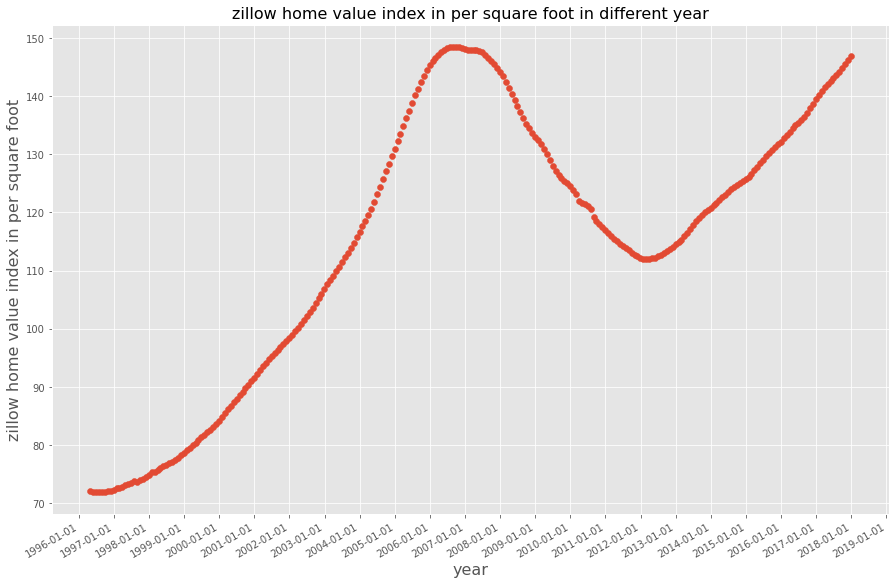

In [64]:
# the ZHVIPerSqft_AllHomes column has many value in same date but for different location. 
# For this notebook we are not interested in location. We mean all the value in same date
#freq = d : date별로 groupby를 하겠다.
#null값은 dropna
df_zhvi_sqft_all = df_city_time_series.set_index('Date') \
                    .groupby(pd.Grouper(freq='d')).mean().dropna(how='all') \
                    .ZHVIPerSqft_AllHomes
print(df_zhvi_sqft_all)

fig,ax = plt.subplots(figsize = (15,10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.title('zillow home value index in per square foot in different year', fontsize = 16)
plt.xlabel('year', fontsize = 16)
plt.ylabel('zillow home value index in per square foot', fontsize = 16)
fig.autofmt_xdate()
plt.show()

# Pre-process the data
- transform data to stationary
- transform data to supervised learning
- scale data to (-1, 1)

In [65]:
# frame a sequence as a supervised learning problem
# this methods will create a column and column value will be 1 shift from the data. 
# it will make our data to supervised so that we can feed into network
# 한칸 후의 값을 예측하도록(lag+1)
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [66]:
# create a differenced series
# this is to make time series stationary
# why stationarity? => https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [67]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train_scaled = scaler.transform(train)
    # transform test
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [68]:

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)

    return inverted[0,-1]

    raise NotImplementedError

  #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
def invert_difference(history, yhat, interval=1):
    x = yhat + history[-interval]
    return x
    raise NotImplementedError


# Define model

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [70]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
# One to One LSTM이지만 stateful = True라고 함으로써 x초값을 추정하기위해 0~x-1초까지의 데이터를 모두 누적해서 추정(가변 Window)
# Epoch이 끝나면 State Reset
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape = (batch_size, X.shape[1], X.shape[2]), stateful = True))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error' , optimizer = 'adam')
    for i in range(nb_epoch) : 
      model.fit(X, y, epochs = 1, batch_size = batch_size, verbose = 0, shuffle = False)
      model.reset_states()
    return model

In [71]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

# Train the model



### Preprocess the data

In [72]:
series = df_zhvi_sqft_all
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1) # interval : 1

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1) # column 2개를 만듬
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.80) # 80% trainm 20% test
train = supervised_values[0:train_size]
test = supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

### Train the model and predict the value

In [73]:
repeats = 5

error_scores = list()
for r in range(repeats) : 
  lstm_model = fit_lstm(train_scaled, 1, 30, 4)
  prediction = list()

  for i in range(len(test_scaled)) : 
    X,y =  test_scaled[i, 0:-1], test_scaled[i,-1]
    yhat = forecast_lstm(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = invert_difference(raw_values, yhat, len(test_scaled)+1-i)
    prediction.append(yhat)

  rmse = np.sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], prediction))
  print('%d) Test RMSE : %.3f' % (r+1, rmse))
  error_scores.append(rmse)

1) Test RMSE : 0.529
2) Test RMSE : 0.523
3) Test RMSE : 0.519
4) Test RMSE : 0.505
5) Test RMSE : 0.517


In [74]:
print(prediction)

[119.39021501972711, 120.14902299472165, 120.58428716896317, 120.89032152236733, 121.25594733435429, 121.66629841480729, 122.08177299537756, 122.52799441262763, 123.0121502533153, 123.4730073820724, 123.9297762181175, 124.36912899120884, 124.74787133277998, 125.04230876909489, 125.33096913911436, 125.6234832325531, 125.96323622865638, 126.42971626841835, 127.06312446647715, 127.78980189946913, 128.46394501146546, 129.04760550040433, 129.6054886737096, 130.21046859388267, 130.758955129858, 131.2235387089215, 131.67951249217603, 132.115855313915, 132.64584408636975, 133.21434109182425, 133.787509511814, 134.40113323519884, 135.00685471841155, 135.44960800479504, 135.81463432495661, 136.264858830301, 136.88504020827483, 137.73797404411857, 138.5988719782897, 139.46334569081682, 140.27118355019314, 140.9988054630848, 141.58994503962563, 142.1178439588199, 142.61714981962666, 143.14809945846483, 143.58303366348142, 143.98466337581664, 144.56277985672835, 145.35846143643062, 146.179461259972

### line plot of observed vs predicted

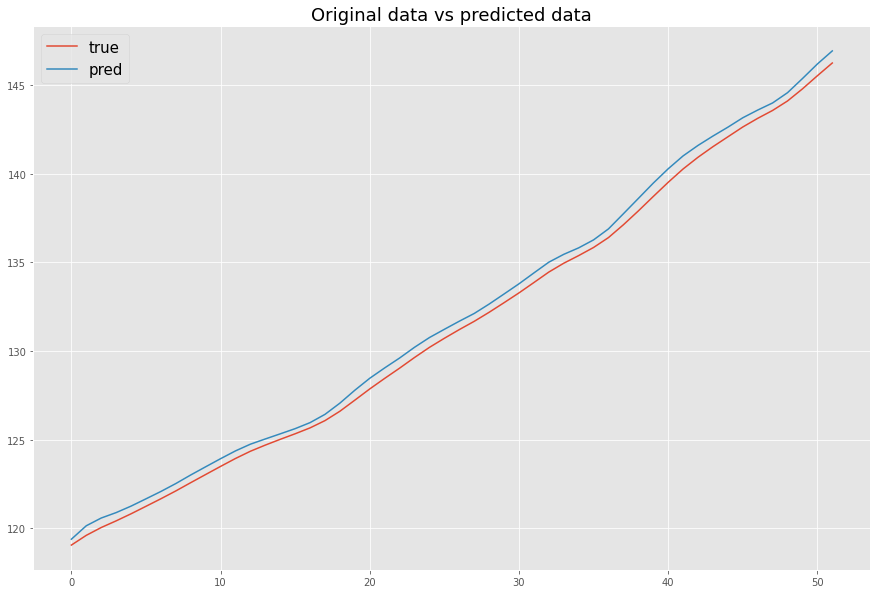

In [75]:
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)], label='true')
plt.plot(prediction, label='pred')
plt.legend(fontsize=15)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

# Predict the house price for next years

In [76]:
# last value of our dataset
last_value = np.array([test_scaled[-1][0]])

In [77]:
# initial record
initial = last_value
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
# AutoRegressive
for i in range(40):
    yhat = forecast_lstm(lstm_model, 1, initial)
    yhat_inver = invert_scale(scaler, initial, yhat)
    if i == 0 : 
      yhat_diff = yhat_inver + raw_values[-1]
    else : 
      yhat_diff = yhat_inver + prediction[i-1]
    prediction.append(yhat_diff)

    initial = np.array([yhat])


### Plot housing price prediction

In [78]:
prediction = np.concatenate(prediction, axis = 0).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

ValueError: ignored

In [ ]:
rng = pd.date_range('2018-01-31 00:00:00', preiods = 40, freq = 'M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index = True, right_index = True, how = 'outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

In [ ]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
middle = original.shape[0]
original

In [ ]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'], inplace = True)

In [ ]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

In [ ]:
plt.rc('figure', figsize = (15,10))

In [ ]:
fig,ax = plt.subplots(figsize = (15,10))
ax.scatter(df_final.index[:middle]. df_final[:middle], label = 'past')
ax.scatter(df_final.index[middle:], df_final[middle:], label = 'future')
ax.xaxis.set_major_locator(mdates.YearLocator(1))

plt.title('zillow home value index in different year', fontsize = 16)
plt.xlabel('year', fontsize = 16)
plt.ylabel('zillow home value index in per square foot', fontsize = 16)
ax.legend(fontsize = 10, loc = 'upper left')
fig.autofmt_xdate()
plt.show()